In [7]:
#This notebook is for testing the download of PIPS data using the web API.
#It uses urllib3 and BeautifulSoup4
%matplotlib notebook
import os
import bs4
import urllib3
import pandas as pd
import xarray as xr
import numpy as np
from pyPIPS.disdrometer_module import avg_diameter, fall_bins, eff_sensor_area, max_diameter, min_diameter, min_fall_bins
import time
import matplotlib.pyplot as plt
from pyPIPS import thermolib as thermo
from pyPIPS import timemodule as tm
from datetime import datetime, timedelta
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
import pyPIPS.plotmodule as pm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Function definitions. These will eventually go into their own module
def scrape_tripips_onesec_data(url, numrecords=3600):
    """Grabs one-second records from the TriPIPS http server. Uses urlib3 and beautifulsoup4"""
    http = urllib3.PoolManager()
    content = http.request('GET', url + '&records={:d}'.format(numrecords))
    soup = bs4.BeautifulSoup(content.data, "lxml")
    table = soup.find('table')
    rows = table.find_all('tr')
    headers = rows.pop(0).find_all('th')
    headers.pop(0)
    headers = [header.string for header in headers]
    data = []
    timestamps = []
    for row in rows:
        tokens = row.find_all('td')
        tokens = [token.string.strip(' "') for token in tokens]
        timestamp = tokens.pop(0)
        tokens = [np.float(token) if token not in ('' or 'NAN') else np.nan for token in tokens]
        data.append(tokens)
        timestamps.append(timestamp)
    index = pd.to_datetime(timestamps, format='%Y-%m-%d %H:%M:%S')
    df = pd.DataFrame(data, columns=headers, index=index)
    return df

def scrape_tripips_tensec_data(url, numrecords=360):
    """Grabs ten-second records from the TriPIPS http server. Uses urlib3 and beautifulsoup4"""
    http = urllib3.PoolManager()
    content = http.request('GET', url + '&records={:d}'.format(numrecords))
    soup = bs4.BeautifulSoup(content.data, "lxml")
    table = soup.find('table')
    rows = table.find_all('tr')
    headers = rows.pop(0).find_all('th')
    headers.pop(0)
    headers = [header.string for header in headers]
    telegrams = []
    spectrum_list = []
    timestamps = []
    for row in rows:
        tokens = row.find_all('td')
        tokens = [token.string.strip(' "') for token in tokens]
        timestamp = tokens.pop(0)
        tokens.pop(0)
        parsivel_string = tokens.pop(0)
        telegram_dict = read_parsivel_telegram(parsivel_string)
        telegrams.append(telegram_dict)
        spectrum = read_parsivel_spectrum(parsivel_string)
        spectrum_list.append(spectrum)
        timestamps.append(timestamp)
        
    index = pd.to_datetime(timestamps, format='%Y-%m-%d %H:%M:%S')
    df_telegram = pd.DataFrame(telegrams, index=index)
    # print(np.array(spectrum_list).shape)
    da_spectrum = xr.DataArray(spectrum_list, coords=[index, fall_bins,
                                                     avg_diameter],
                              dims=['time', 'velocity', 'diameter'])
    return df_telegram, da_spectrum
    
def read_parsivel_telegram(parsivel_string):
    """
    Reads the parsivel telegram and returns a dictionary for each component,
    except for the spectrum, which is handled separately by read_spectrum.
    """
    # print(parsivel_string)
    parsivel_tokens = parsivel_string.strip(' "').split(';')
    # print(parsivel_tokens)
    parsivel_tokens = parsivel_tokens[:11]
    
    
    parsivel_telegram_dict = {
        'parsivel_id': int(parsivel_tokens[0]),
        'rain rate (mm/hr)': float(parsivel_tokens[1]),
        'rain accumulation (mm)': float(parsivel_tokens[2]),
        'radar reflectivity (dBZ)': float(parsivel_tokens[3]),
        'sample interval': int(parsivel_tokens[4]),
        'signal amplitude': int(parsivel_tokens[5]),
        'particle count': int(parsivel_tokens[6]),
        'sensor temp': int(parsivel_tokens[7]),
        'power supply voltage': float(parsivel_tokens[8]),
        'sensor time': parsivel_tokens[9],
        'sensor date': parsivel_tokens[10]
    }
    
    return parsivel_telegram_dict

def read_parsivel_spectrum(parsivel_string):
    """Given a raw string of Parsivel data, extract the DSD spectrum from it."""
    parsivel_tokens = parsivel_string.strip(' "').split(';')
    #parsivel_tokens = parsivel_tokens.strip('"')
    spectrum = [float(x) if ('' or '\n' or '\r') not in x else 0 for x in parsivel_tokens[11:]]
    try:
        spectrum = [float(x) if ('' or '\n' or '\r') not in x else 0 for x in parsivel_tokens[11:]]
    except ValueError:
        spectrum = [-999 for i in range(1025)]
    # Strip off bogus final value (why is it there?)
    if len(spectrum) == 1025:
        spectrum = spectrum [:-1]
    # Reshape the spectrum to a 32x32 matrix of integers
    spectrum = np.array(spectrum, dtype='int')
    # Assert that the size of the array is what we expect
    # Otherwise generate a spectrum of missing values (-999)
    if(spectrum.size == 1024):
        spectrum = spectrum.reshape((32, 32))
    else:
        spectrum = -999 * np.ones((32, 32), dtype='int')
    return spectrum

def timestamp2datetime(timestamp):
    """Construct a datetime object from a timestamp of the form YYYY-MM-DD HH:MM:SS.XXX"""
    date, time = timestamp.strip().split()
    year = np.int(date[:4])
    month = np.int(date[5:7])
    day = np.int(date[8:])
    hour = np.int(time[:2])
    min = np.int(time[3:5])
    sec = np.int(time[6:8])
    
    return datetime(year, month, day, hour, min, sec)

def calc_ND_da(spectrum_da, interval=10, use_measured_fs=True):
    """Computes the number concentration from the 32x32 spectrum"""
    index = spectrum_da.coords['time'].values
    if not use_measured_fs:
        raise NotImplementedError('Not yet implemented: use measured fall speed for now!')
    else:
        ND_da = spectrum_da.groupby('time').apply(calc_ND)
    
    #ND_df = pd.DataFrame(ND_arr, columns=avg_diameter, index=index)
    return ND_da 

def calc_ND_list(spectrum_list, interval=10, use_measured_fs=True):
    ND_list = [calc_ND(spectrum, interval=DSD_interval) for spectrum in spectrum_list]
    ND_arr = np.array(ND_list)
    return ND_arr

def calc_ND(spectrum, interval=10, use_measured_fs=True):
    _, vspectrum = np.meshgrid(avg_diameter, fall_bins)
    dspectrum = spectrum
    if np.all(dspectrum == -999):
        # print('Here!')
        ND = -999. * np.ones_like(avg_diameter)
        ND = np.ma.masked_where(ND == -999., ND)
    else:
        ND = dspectrum / (vspectrum * interval * eff_sensor_area * (max_diameter - min_diameter))
        if use_measured_fs:
            # ND = ND.sum(axis=0)
            ND = ND.sum(dim='velocity')
    return ND

In [9]:
# Set up directories for output/plotting and URLs for grabbing the data
# base_output_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/TriPIPS/webdata/'
base_output_dir = '/Users/dawson29/sshfs_mounts/stormlab_web/'
image_output_dir = os.path.join(base_output_dir, 'images')
base_url = "http://10.163.29.26/?command=TableDisplay&table="
onesec_table = "One_Hz"
tensec_table = "Ten_Hz"
url_onesec = base_url + onesec_table
url_tensec = base_url + tensec_table

In [10]:
# Set up dictionaries to control plotting parameters

dateformat = '%H:%M'

# Temperature and dewpoint
temp_dewp_ax_params = {
    'majorxlocator': dates.MinuteLocator(byminute=[0, 15, 30, 45], interval=1), 
    'majorxformatter': dates.DateFormatter(dateformat),
    'minorxlocator': dates.MinuteLocator(byminute=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55], interval=1),
    'axeslimits': [None, (-5., 35.)],
    'axeslabels': ['Time (H:M) UTC', r'Temperature ($^{\circ}$C)']
}

# Wind speed and direction
windspd_ax_params = {
    'majorxlocator': dates.MinuteLocator(byminute=[0, 15, 30, 45], interval=1), 
    'majorxformatter': dates.DateFormatter(dateformat),
    'minorxlocator': dates.MinuteLocator(byminute=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55], interval=1),
    'axeslimits': [None, [0.0, 25.0]],
    'axeslabels': ['Time (H:M) UTC', r'wind speed (m s$^{-1}$)']
}

winddir_ax_params = {
    'majorylocator': ticker.MultipleLocator(45.),
    'axeslimits': [None, [0.0, 360.0]],
    'axeslabels': [None, r'Wind direction ($^{\circ}$C)']
}

pressure_ax_params = {
    'majorylocator': ticker.MultipleLocator(5.),
    'axeslimits': [None, [940., 980.]],
    'axeslabels': [None, r'Pressure (hPa)']
}



# Number concentration
log_ND_params = {
    'type': 'pcolor', 
    'vlimits': [-1.0, 3.0],
    'clabel': r'log[N ($m^{-3} mm^{-1}$)]'
}

log_ND_ax_params = {
    'majorxlocator': dates.MinuteLocator(byminute=[0, 15, 30, 45], interval=1), 
    'majorxformatter': dates.DateFormatter(dateformat),
    'minorxlocator': dates.MinuteLocator(byminute=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55], interval=1),
    'axeslimits': [None, [0.0, 9.0]],
    'majorylocator': ticker.MultipleLocator(base=1.0),
    'axeslabels': [None, 'D (mm)']
}

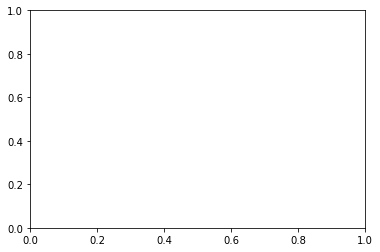

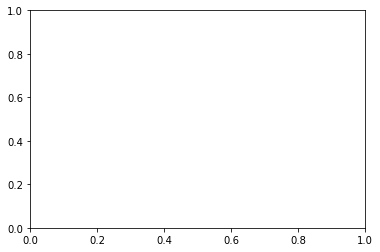

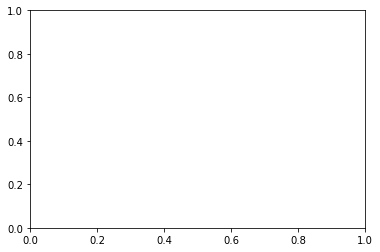

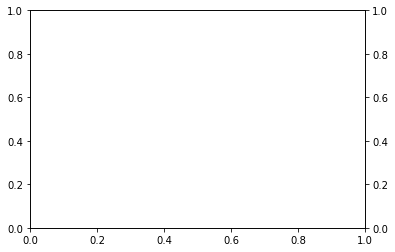

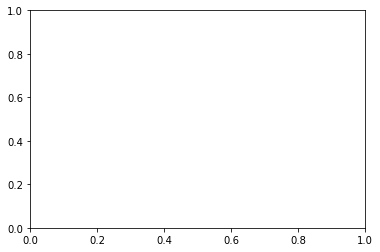

In [11]:
%matplotlib inline
# Testing real-time plotting loop
from IPython import display

interval_onesec = 1.
interval_tensec = 10.

plot_update_interval = 60 # seconds
plot_update_interval_ts = pd.Timedelta(seconds=plot_update_interval)
keep_data_for = 3600 # seconds
keep_data_for_ts = pd.Timedelta(seconds=keep_data_for)
numrecords_onesec = int(keep_data_for / interval_onesec)
numrecords_tensec = int(keep_data_for / interval_tensec)

# Grab and process the initial period of data
onesec_df = scrape_tripips_onesec_data(url_onesec, numrecords=numrecords_onesec)
print(onesec_df.keys())
onesec_df['Dewpoint'] = thermo.calTdfromRH(onesec_df['Pressure'] * 100., onesec_df['SlowTemp'] + 273.15, 
                                     onesec_df['RH'] / 100.) - 273.15
telegram_df, spectrum_da = scrape_tripips_tensec_data(url_tensec, numrecords=numrecords_tensec)
ND_da = calc_ND_da(spectrum_da)

# TODO: figure out an efficient way to dump data containing regular intervals (i.e. hourl) to netCDF files.
# May eventually be able to replace current dumping of proprietary files to the flash drive on the CR6.

# fig, ax = plt.subplots()
# onesec_df.plot(ax=ax, y=['SlowTemp', 'Dewpoint'], ylim=(-5.,5.), color=['r', 'g'])

fig, ax = plt.subplots()
fig_vd, ax_vd = plt.subplots()
fig_t_td, ax_t_td = plt.subplots()
fig_wind, ax_windspd = plt.subplots()
ax_winddir = ax_windspd.twinx()
fig_pressure, ax_pressure = plt.subplots()
#plt.ion()
#fig.show()
#fig.canvas.draw()
display.display(fig)
display.display(fig_vd)
display.display(fig_t_td)
display.display(fig_wind)
display.display(fig_pressure)
display.clear_output(wait=True)
numrecords_append_tensec=10
numrecords_append_onesec=120
numiter=1
# onesec_new_df = scrape_tripips_onesec_data(url_onesec, numrecords=numrecords)
# onesec_new_df['Dewpoint'] = thermo.calTdfromRH(onesec_new_df['Pressure'] * 100., onesec_new_df['SlowTemp'] + 273.15, 
#                                                onesec_new_df['RH'] / 100.) - 273.15
# # Append new data onto onesec_df
# onesec_df = onesec_df.append(onesec_new_df)
# # Drop duplicate timestamps
# onesec_df = onesec_df[~onesec_df.index.duplicated(keep='first')]
# # Drop records older than specified time
# last_timestamp = onesec_df.index[-1]
# oldest_timestamp = last_timestamp-keep_data_for
# onesec_df = onesec_df[oldest_timestamp:]
# onesec_df.plot(ax=ax, y=['SlowTemp', 'Dewpoint'], ylim=(-5.,5.), colors=['r', 'g'])

In [13]:
#%%time
#for i in range(numiter):
while True:
    ax.clear()
    ax_vd.clear()
    ax_t_td.clear()
    ax_windspd.clear()
    ax_winddir.clear()
    ax_pressure.clear()
    onesec_new_df = scrape_tripips_onesec_data(url_onesec, numrecords=numrecords_append_onesec)
    onesec_new_df['Dewpoint'] = thermo.calTdfromRH(onesec_new_df['Pressure'] * 100., onesec_new_df['SlowTemp'] + 273.15, 
                                     onesec_new_df['RH'] / 100.) - 273.15
    # Append new data onto onesec_df
    onesec_df = onesec_df.append(onesec_new_df)
    # Drop duplicate timestamps
    onesec_df = onesec_df[~onesec_df.index.duplicated(keep='first')]
    # Drop records older than desired interval
    last_timestamp_onesec = onesec_df.index[-1]
    oldest_timestamp_onesec = last_timestamp_onesec-keep_data_for_ts
    onesec_df = onesec_df.loc[oldest_timestamp_onesec:]
    plottimes_onesec = [onesec_df.index.to_pydatetime()]
    # Temperature and Dewpoint
    fields_to_plot_onesec = [onesec_df['SlowTemp'].values, onesec_df['Dewpoint'].values]
    field_parameters_onesec = [pm.temp_params, pm.dewpoint_params]
    ax_t_td = pm.plotmeteogram(ax_t_td, plottimes_onesec, fields_to_plot_onesec, field_parameters_onesec)
    temp_dewp_ax_params['axeslimits'][0] = (plottimes_onesec[0][0], plottimes_onesec[0][-1]) 
    ax_t_td, = pm.set_meteogram_axes([ax_t_td], [temp_dewp_ax_params])
    # Wind speed and direction
    ax_windspd = pm.plotmeteogram(ax_windspd, plottimes_onesec, [onesec_df['WS_ms'].values], [pm.windspeed_params])
    ax_winddir = pm.plotmeteogram(ax_winddir, plottimes_onesec, [onesec_df['WindDir'].values], [pm.winddir_params])
    windspd_ax_params['axeslimits'][0] = (plottimes_onesec[0][0], plottimes_onesec[0][-1])
    winddir_ax_params['axeslimits'][0] = (plottimes_onesec[0][0], plottimes_onesec[0][-1])
    ax_windspd, ax_winddir = pm.set_meteogram_axes([ax_windspd, ax_winddir], [windspd_ax_params, winddir_ax_params])
    # Pressure
    pmin = np.nanmin(onesec_df['Pressure'].values)
    pmax = np.nanmax(onesec_df['Pressure'].values)
    pressure_ax_params['axeslimits'] = [None, [pmin - 2.5, pmax + 2.5]]
    fields_to_plot_press = [onesec_df['Pressure'].values]
    field_parameters_press = [pm.pressure_params]
    ax_pressure = pm.plotmeteogram(ax_pressure, plottimes_onesec, fields_to_plot_press, field_parameters_press)
    ax_pressure, = pm.set_meteogram_axes([ax_pressure], [pressure_ax_params])
    

    # DSD plots
    telegram_new_df, spectrum_new_da = scrape_tripips_tensec_data(url_tensec, numrecords=numrecords_append_tensec)
    ND_new_da = calc_ND_da(spectrum_new_da)
    # Append new data onto the data array
    ND_da = xr.concat([ND_da, ND_new_da], dim='time')
    # Drop duplicate timestamps
    ND_da = ND_da.groupby('time').first()
    # onesec_df = onesec_df[~onesec_df.index.duplicated(keep='first')]
    # Drop records older than desired interval
    last_timestamp = ND_da['time'].to_index()[-1]
    spectrum = spectrum_new_da.loc[last_timestamp]
    # print(last_timestamp)
    oldest_timestamp = last_timestamp-keep_data_for_ts
    ND_da = ND_da.loc[oldest_timestamp:]
    plottimes = [ND_da['time'].to_index().to_pydatetime()]
    ND_arr = ND_da.values.T
    logND_arr = np.ma.log10(ND_arr)
    fields_to_plot = [logND_arr]
    field_parameters = [log_ND_params]
    ax = pm.plotmeteogram(ax, plottimes, fields_to_plot, field_parameters, 
                          yvals=[min_diameter] * len(fields_to_plot))
    ax, = pm.set_meteogram_axes([ax], [log_ND_ax_params])
    ax_vd.set_title('Fall speed vs. diameter for time {0}'.format(last_timestamp.strftime(tm.timefmt2)))
    countsplot = np.ma.masked_where(spectrum.values <= 0, spectrum)
    C = ax_vd.pcolor(min_diameter, min_fall_bins, countsplot, vmin=1, vmax=50, edgecolors='w')
    divider = make_axes_locatable(ax_vd)
    cax = divider.append_axes("right", size="5%")
    cb = fig_vd.colorbar(C, cax=cax, orientation='vertical')
    ax_vd.set_xlim(0.0, 10.0)
    ax_vd.xaxis.set_major_locator(ticker.MultipleLocator(2.0))
    ax_vd.set_xlabel('diameter (mm)')
    ax_vd.set_ylim(0.0, 10.0)
    ax_vd.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax_vd.set_ylabel('fall speed (m/s)')
    
    display.display(fig)
    display.display(fig_vd)
    display.display(fig_t_td)
    display.display(fig_wind)
    display.display(fig_pressure)
    display.clear_output(wait=True)
    # fig.canvas.draw()
    fig.savefig(os.path.join(image_output_dir, 'logND_current.png'), dpi=300)
    fig_vd.savefig(os.path.join(image_output_dir, 'VD_current.png'), dpi=300)
    fig_t_td.savefig(os.path.join(image_output_dir, 'T_Td_current.png'), dpi=300)
    fig_wind.savefig(os.path.join(image_output_dir, 'wind_current.png'), dpi=300)
    fig_pressure.savefig(os.path.join(image_output_dir, 'pressure.png'), dpi=300)
    
    # plt.pause(0.01)
    # Sleep for the desired interval. This may not be perfectly accurate
    time.sleep(plot_update_interval)

KeyboardInterrupt: 